# Job Recommendation Engine

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Model Training with Machine Learning](#training)
* [Model Training with Deep Learning](#dtraining)
* [Output](#output)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this project, a job recommendation engine will be built, which will tell us the top 15 recommended jobs according to the input given that in which field the job is required, based on job postings in the New York City. Recommendations will be made using machine learning models and further, model performance will be improved using neural networks training.
The dataset is obtained from kaggle https://www.kaggle.com/new-york-city/new-york-city-current-job-postings.

In [1]:
# reading file from a filepath with apache spark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")

# creating an instance of spark context class
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
spark = SparkSession.builder.appName('Data Exploration').getOrCreate()

## Data <a name="data"></a>

In [2]:
rdd = sc.textFile('Dataset/nyc_jobPostings.csv')
df = spark.read.csv(rdd, header=True)
df.show()

+------+--------------------+------------+---------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|Job ID|              Agency|Posting Type|Vacancies|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recruitment Contact|Residency Requirement|     

In [3]:
# separate required columns
df1 = df[['Job ID', 'Agency', 'Vacancies', 'Business Title', 'Job Category', 'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To', 'Work Location', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills', 'Additional Information']]
df1.show()

+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|Vacancies|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|       Work Location|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|        1|     Account Manager|                null|                         null|            42405|          65485| 110 William St. N Y|Division of Econo...|     "1.	A baccalaurea...| all candidat

In [4]:
# ensuring all columns have proper datatypes
# !pip install pyspark
from pyspark.sql.types import *

df1 = df1.withColumn('Vacancies', df1['Vacancies'].cast(IntegerType()))
df1 = df1.withColumn('Salary Range From', df1['Salary Range From'].cast(FloatType()))
df1 = df1.withColumn('Salary Range To', df1['Salary Range To'].cast(FloatType()))
df1.dtypes

[('Job ID', 'string'),
 ('Agency', 'string'),
 ('Vacancies', 'int'),
 ('Business Title', 'string'),
 ('Job Category', 'string'),
 ('Full-Time/Part-Time indicator', 'string'),
 ('Salary Range From', 'float'),
 ('Salary Range To', 'float'),
 ('Work Location', 'string'),
 ('Job Description', 'string'),
 ('Minimum Qual Requirements', 'string'),
 ('Preferred Skills', 'string'),
 ('Additional Information', 'string')]

In [5]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")        # fastens toPandas conversion for large datasets
df_p = df1.toPandas()
print(df_p.dtypes)
df_p.head()

Job ID                            object
Agency                            object
Vacancies                          int32
Business Title                    object
Job Category                      object
Full-Time/Part-Time indicator     object
Salary Range From                float32
Salary Range To                  float32
Work Location                     object
Job Description                   object
Minimum Qual Requirements         object
Preferred Skills                  object
Additional Information            object
dtype: object


,Job ID,Agency,Vacancies,Business Title,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Work Location,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information
0,87990,DEPARTMENT OF BUSINESS SERV.,1,Account Manager,None,None,42405.000000,65485.000000,110 William St. N Y,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,â€¢\tExcellent interpersonal and organizationa...
1,97899,DEPARTMENT OF BUSINESS SERV.,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",None,F,60740.000000,162014.000000,110 William St. N Y,The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,None
2,132292,NYC HOUSING AUTHORITY,52,Maintenance Worker - Technical Services-Heatin...,Maintenance & Operations,F,51907.679688,54580.320312,Heating Mgt-Operations,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,or construction trades in a trade school or v...
3,132292,NYC HOUSING AUTHORITY,52,Maintenance Worker - Technical Services-Heatin...,Maintenance & Operations,F,51907.679688,54580.320312,Heating Mgt-Operations,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,or construction trades in a trade school or v...
4,133921,NYC HOUSING AUTHORITY,50,Temporary Painter,Maintenance & Operations,F,35.000000,35.000000,DMP-Contract & Analysis Unit,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,SPECIAL NOTE: 1. This is a temporary assig...


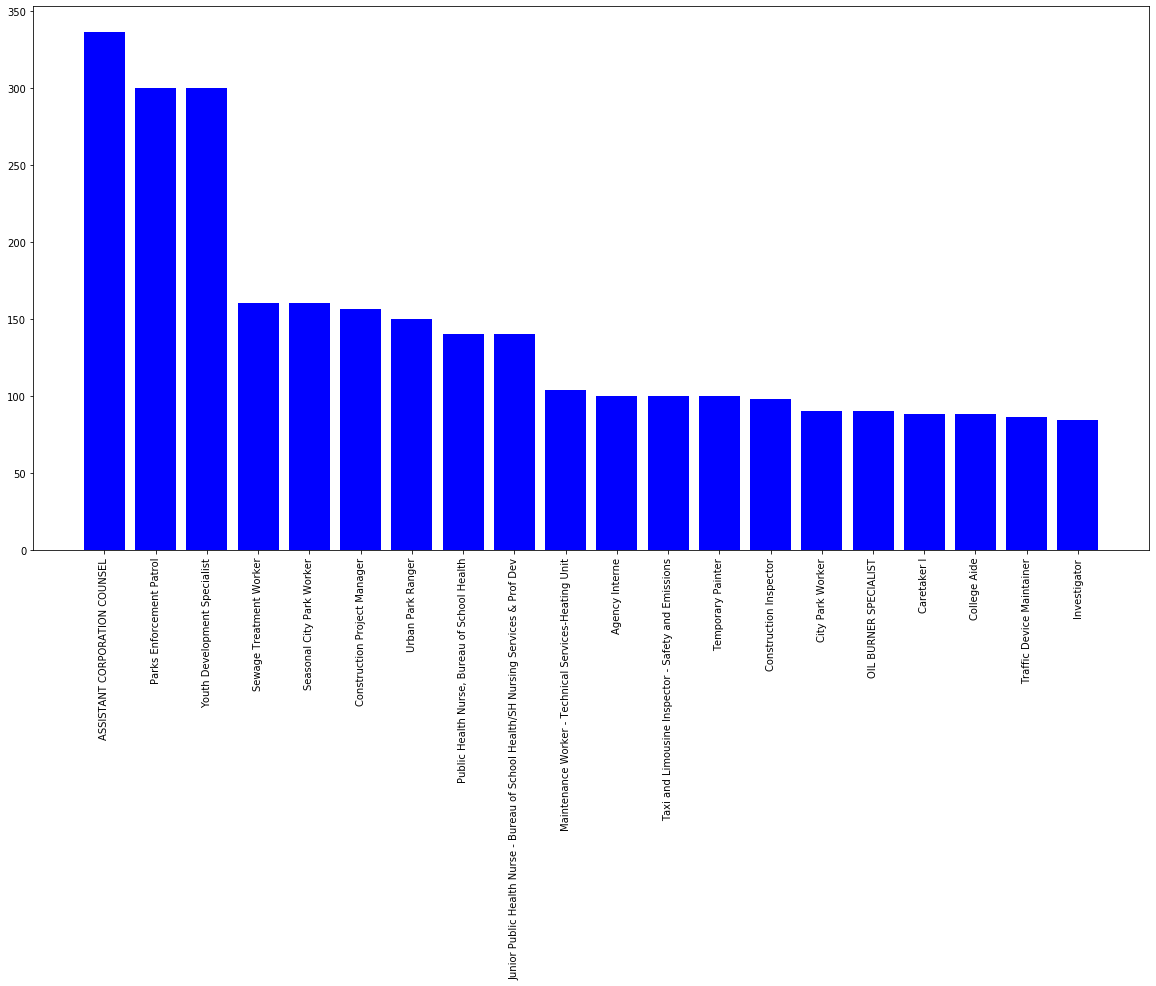

In [6]:
# visualization for number of positions for each job
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_vacancies = df_p.groupby('Business Title')['Vacancies'].sum().sort_values(ascending=False).head(20)
df_vacancies = df_vacancies.reset_index()

plt.figure(figsize=(20, 10))
plt.bar(df_vacancies['Business Title'], df_vacancies['Vacancies'], color='blue')
plt.xticks(df_vacancies['Business Title'], rotation=90)
plt.show()

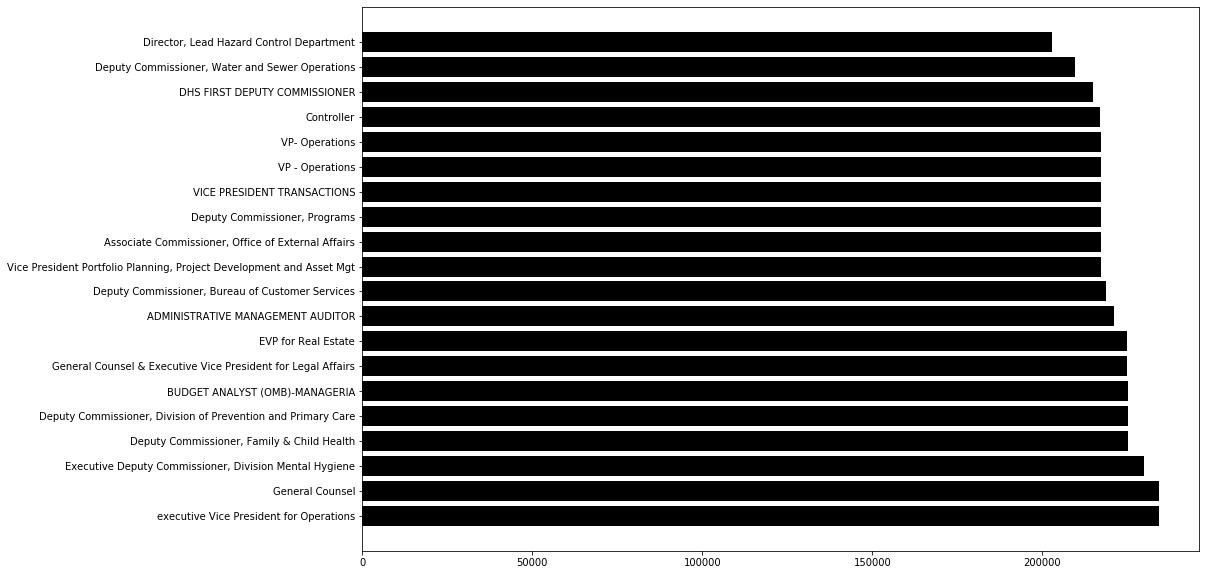

In [7]:
# visualization for highest salary jobs
df_pay = df_p.groupby('Business Title')['Salary Range To'].mean().sort_values(ascending=False).head(20)
df_pay = df_pay.reset_index()

plt.figure(figsize=(15, 10))
plt.barh(df_pay['Business Title'], df_pay['Salary Range To'], color='black')
plt.show()

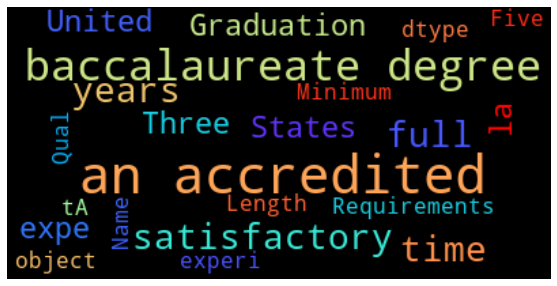

In [8]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# [STOPWORDS.update(n) for n in ['NaN', 'None', 'english']]
sw = ['tA', 'th', 'tAt'] + list(STOPWORDS)
# sw = set(STOPWORDS)
# sw.update(['NaN', 'None', 'tA', 'th', 'tAt'])

# generating a wordcloud image out of minimum qulaity requirements
plt.figure(figsize=(15, 5))
wc = WordCloud(stopwords=sw, colormap='rainbow', max_words=200).generate_from_text(str(df_p['Minimum Qual Requirements']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

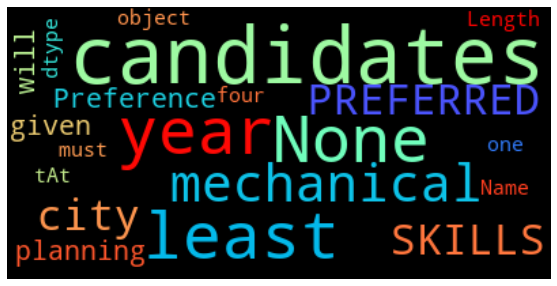

In [9]:
# generating a wordcloud image out of preferred skills
plt.figure(figsize=(15, 5))
wc = WordCloud(stopwords=sw, colormap='rainbow', max_words=200).generate_from_text(str(df_p['Preferred Skills']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Methodology <a name="methodology"></a>

In [10]:
# majority of the missing value columns are non numerical, hence can't be modified and also can't be deleted as it would reduce the dataset
# ****making an assumption about Full-Time/Part-Time indicator column and replacing the null columns only
from pyspark.sql.functions import when, col

df1 = df1.withColumn('Full-Time/Part-Time indicator', \
                     when((df1['Salary Range From'] > 50) & (col('Full-Time/Part-Time indicator').isNull()), 'F').otherwise(df1['Full-Time/Part-Time indicator']))

df1 = df1.withColumn('Full-Time/Part-Time indicator', \
                     when((df1['Salary Range From'] < 50) & (col('Full-Time/Part-Time indicator').isNull()), 'P').otherwise(df1['Full-Time/Part-Time indicator']))

df1.show()

+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|Vacancies|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|       Work Location|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+---------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|        1|     Account Manager|                null|                            F|          42405.0|        65485.0| 110 William St. N Y|Division of Econo...|     "1.	A baccalaurea...| all candidat

### Feature Engineering

In [11]:
# separating strings in minimum qual requirements and preferred skills column and applying one-hot encoding
# challenge:
# 1. Strings are saparated by random punctuation marks rather than commas
# 2. Number of string values in the column for each job is different
# splitting the strings and put them in a single list
from pyspark.sql.functions import split

df_mqr = df1.withColumn('Minimum Qual Requirements', split('Minimum Qual Requirements', ' '))   # using , as delimiter will give error in keywords detection
df_ps = df_mqr.withColumn('Preferred Skills', split('Preferred Skills', ' ')) 

In [12]:
df_red = df_ps[['Business Title', 'Vacancies', 'Salary Range From', 'Minimum Qual Requirements', 'Preferred Skills', 'Work Location']]
df_red.show()

+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+
|      Business Title|Vacancies|Salary Range From|Minimum Qual Requirements|    Preferred Skills|       Work Location|
+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+
|     Account Manager|        1|          42405.0|     ["1.	A, baccalaur...|[, all, candidate...| 110 William St. N Y|
|EXECUTIVE DIRECTO...|        1|          60740.0|     ["1., A, baccalau...|                null| 110 William St. N Y|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Opera...|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Opera...|
|   Temporary Painter|       50|             35.0|     [1., Five, years,...|                null|DMP-Contract & An...|
|   Temporary Painter|       50|             35.

In [13]:
# counting number of values in minimum qual requirements and preferred skills
from pyspark.sql.functions import size

mqr = df_red.select('*', size('Minimum Qual Requirements').alias('Qualities Count'))
ps = mqr.select('*', size('Preferred Skills').alias('Skills Count'))

ps.show()

+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+---------------+------------+
|      Business Title|Vacancies|Salary Range From|Minimum Qual Requirements|    Preferred Skills|       Work Location|Qualities Count|Skills Count|
+--------------------+---------+-----------------+-------------------------+--------------------+--------------------+---------------+------------+
|     Account Manager|        1|          42405.0|     ["1.	A, baccalaur...|[, all, candidate...| 110 William St. N Y|             71|          16|
|EXECUTIVE DIRECTO...|        1|          60740.0|     ["1., A, baccalau...|                null| 110 William St. N Y|            140|          -1|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Opera...|             63|           2|
|Maintenance Worke...|       52|         51907.68|     ["1., Three, year...|      [, mechanical]|Heating Mgt-Ope

In [14]:
# some preferred skills have size = -1
# finding correlation between salary and minimum qual requirements and preferred skills
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Normalizer

assembler = VectorAssembler(inputCols=['Salary Range From', 'Qualities Count', 'Skills Count'], outputCol='Vector_Col')
assembled = assembler.transform(ps).select('Vector_Col')
matrix = Correlation.corr(assembled, 'Vector_Col')
matrix.collect()[0]['pearson({})'.format('Vector_Col')].values

array([ 1.        , -0.00607287,  0.16130972, -0.00607287,  1.        ,
       -0.08856486,  0.16130972, -0.08856486,  1.        ])

## Model Training with Machine Learning <a name='training'></a>

In [15]:
import pandas as pd
from pyspark.sql import functions as F

In [16]:
df_model = df[['Job ID', 'Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills', 'Work Location']]

In [17]:
df1_model = df_model.withColumn('Merged Columns', F.concat(F.col('Business Title'), F.lit(' '), F.col('Job Description'), F.lit(' '), F.col('Minimum Qual Requirements'), F.lit(' '), F.col('Preferred Skills')))
df1_model.show()

+------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+
|Job ID|      Business Title|     Job Description|Minimum Qual Requirements|    Preferred Skills|       Work Location|      Merged Columns|
+------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+
| 87990|     Account Manager|Division of Econo...|     "1.	A baccalaurea...| all candidates m...| 110 William St. N Y|Account Manager D...|
| 97899|EXECUTIVE DIRECTO...|The New York City...|     "1. A baccalaurea...|                null| 110 William St. N Y|                null|
|132292|Maintenance Worke...|Under direct supe...|     "1. Three years o...|          mechanical|Heating Mgt-Opera...|Maintenance Worke...|
|132292|Maintenance Worke...|Under direct supe...|     "1. Three years o...|          mechanical|Heating Mgt-Opera...|Maintenance Worke...|
|133921|   Temporary

In [18]:
# converting into pandas due to complexity of defining a new desired column in spark
dfp_model = df1_model.toPandas()
dfp_model.head()

,Job ID,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills,Work Location,Merged Columns
0,87990,Account Manager,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,110 William St. N Y,Account Manager Division of Economic & Financi...
1,97899,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,110 William St. N Y,None
2,132292,Maintenance Worker - Technical Services-Heatin...,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Heating Mgt-Operations,Maintenance Worker - Technical Services-Heatin...
3,132292,Maintenance Worker - Technical Services-Heatin...,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Heating Mgt-Operations,Maintenance Worker - Technical Services-Heatin...
4,133921,Temporary Painter,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,DMP-Contract & Analysis Unit,None


In [19]:
# coverting data type into string from object
dfp_model['Merged Columns'] = dfp_model['Merged Columns'].astype(str)

In [20]:
# converting into Title case the required column values
dfp_model['Business Title'] = dfp_model['Business Title'].str.title()
dfp_model['Merged Columns'] = dfp_model['Merged Columns'].str.title()
dfp_model.head()

,Job ID,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills,Work Location,Merged Columns
0,87990,Account Manager,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,110 William St. N Y,Account Manager Division Of Economic & Financi...
1,97899,"Executive Director, Business Development",The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,110 William St. N Y,None
2,132292,Maintenance Worker - Technical Services-Heatin...,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Heating Mgt-Operations,Maintenance Worker - Technical Services-Heatin...
3,132292,Maintenance Worker - Technical Services-Heatin...,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Heating Mgt-Operations,Maintenance Worker - Technical Services-Heatin...
4,133921,Temporary Painter,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,DMP-Contract & Analysis Unit,None


In [21]:
# !pip install rake-nltk
from rake_nltk import Rake
import nltk

In [22]:
# Extracting Keywords
# defining new column
dfp_model['Keywords'] = ''

for index, row in dfp_model.iterrows():
    keywords = row['Merged Columns']
    
    # Instantiating Rake, by default it uses english stopwords from NLTK and discards all puntuation characters as well
    r = Rake()
    
    # Extracting words by passing text
    r.extract_keywords_from_text(keywords)
    
    # Getting the dictionary with keywords as keys and their scores as values
    keywords_dict_scores = r.get_word_degrees()
    
    # Assigning the keywords to the new column
    row['Keywords'] = list(keywords_dict_scores.keys())
    
# Dropping the Merged Column, its job's done
dfp_model.drop(columns = ['Merged Columns'], inplace = True)    

In [23]:
dfp_model.drop_duplicates(subset='Business Title', inplace=True)
dfp_model.set_index('Business Title', inplace=True)
print(dfp_model.columns)
dfp_model.head()

Index(['Job ID', 'Job Description', 'Minimum Qual Requirements',
       'Preferred Skills', 'Work Location', 'Keywords'],
      dtype='object')


,Job ID,Job Description,Minimum Qual Requirements,Preferred Skills,Work Location,Keywords
Business Title,,,,,,
Account Manager,87990,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,110 William St. N Y,"[wbe, work, compliance, owned, business, enter..."
"Executive Director, Business Development",97899,The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,110 William St. N Y,[none]
Maintenance Worker - Technical Services-Heating Unit,132292,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Heating Mgt-Operations,"[work, following, vacuum, tank, 2, responsibil..."
Temporary Painter,133921,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,DMP-Contract & Analysis Unit,[none]
Contract Analyst,137433,** OPEN TO PERMANENT PROCUREMENT ANALYSTS ONLY...,"""1. A baccalaureate degree from an accredited ...",individuals must have,42-09 28th Street,"[purchases, hiv, prevention, --, conduct, ad, ..."


In [24]:
dfp1_model = dfp_model[['Job ID', 'Keywords', 'Work Location']]
dfp1_model.head()

,Job ID,Keywords,Work Location
Business Title,,,
Account Manager,87990,"[wbe, work, compliance, owned, business, enter...",110 William St. N Y
"Executive Director, Business Development",97899,[none],110 William St. N Y
Maintenance Worker - Technical Services-Heating Unit,132292,"[work, following, vacuum, tank, 2, responsibil...",Heating Mgt-Operations
Temporary Painter,133921,[none],DMP-Contract & Analysis Unit
Contract Analyst,137433,"[purchases, hiv, prevention, --, conduct, ad, ...",42-09 28th Street


In [25]:
dfp1_model['Keywords'] = dfp1_model['Keywords'].apply(', '.join)
dfp1_model.head()

,Job ID,Keywords,Work Location
Business Title,,,
Account Manager,87990,"wbe, work, compliance, owned, business, enterp...",110 William St. N Y
"Executive Director, Business Development",97899,none,110 William St. N Y
Maintenance Worker - Technical Services-Heating Unit,132292,"work, following, vacuum, tank, 2, responsibili...",Heating Mgt-Operations
Temporary Painter,133921,none,DMP-Contract & Analysis Unit
Contract Analyst,137433,"purchases, hiv, prevention, --, conduct, ad, 2...",42-09 28th Street


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
# training using TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(dfp1_model['Keywords'])

In [28]:
# generating cosine similarity matrix
csm = cosine_similarity(tfidf_matrix, tfidf_matrix)
csm

array([[1.        , 0.        , 0.00525904, ..., 0.01478619, 0.01012936,
        0.00831139],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00525904, 0.        , 1.        , ..., 0.00461473, 0.00613796,
        0.00485755],
       ...,
       [0.01478619, 0.        , 0.00461473, ..., 1.        , 0.01746004,
        0.012815  ],
       [0.01012936, 0.        , 0.00613796, ..., 0.01746004, 1.        ,
        0.01117172],
       [0.00831139, 0.        , 0.00485755, ..., 0.012815  , 0.01117172,
        1.        ]])

In [29]:
# recommendation function
# making a business title Series, so they are associated to an ordered numerical list, that will be used in the function to match the indices
indices = pd.Series(dfp1_model.index)

# defining a function that takes business title as input and returns top 15 recommended jobs accordingly
def recommend(title, csm=csm):
    
    # initialization of empty list of recommended jobs
    recommended_jobs = []
    locations = []
    
    # getting the index of the job with matching title
    idx = indices[indices == title].index[0]
    
    # creating a series with descending order of similarity scores
    score_series = pd.Series(csm[idx]).sort_values(ascending=False)
    
    # obtaining the indices of top 10 most similar jobs
    top15_indices = list(score_series.iloc[0:15].index)
    
    # inserting the jobs in the recommendations' list
    for i in top15_indices:
        recommended_jobs.append(list(dfp1_model.index)[i])
        locations.append(list(dfp1_model['Work Location'])[i])
        
    recommendations = pd.DataFrame({'Job Roles': recommended_jobs, 'Location': locations}).style.hide_index()
        
    return recommendations

## Output <a name='output'></a>

In [30]:
# testing the recommendation system
recommend('Account Manager')

Job Roles,Location
Account Manager,110 William St. N Y
Minority/Women-Owned Business Enterp. Liaison,4 World Trade Center
Strategic Projects Manager,OFC OF PUBLIC/PRIVATE PARTNERS
Events Specialist,"1 Centre St., N.Y."
Retrofit Accelerator Outreach And Marketing Coordinator,253 Broadway New York Ny
Constituent Services Liaison,"1 Centre St., N.Y."
Project Development Coordinator For Capital Projects,Flushing Meadow Pk Olmsted Ctr
"Compliance Manager, Mayor'S Office Of M/Wbe",253 Broadway New York Ny
"Zone Coordinator, Far Rockaway And Jamaica",REES - Zone Coordination
Data And Operations Analyst,110 William St. N Y


In [31]:
# testing keywords
dfp1_model.iloc[dfp1_model.index.get_loc('Data And Operations Analyst')]['Keywords']

'especially, related, well, 2, tracking, impact, center, "", priorities, new, tools, sbs, executive, staff, support, quality, assurance, including, identifying, policies, baccalaureate, degree, tasks, working, duties, described, program, initiatives, successfully, â, €¢, conduct, policy, systems, qualitative, office, performance, indicators, time, six, years, budget, management, analyst, elected, officials, york, city, business, development, practices, synthesize, complex, information, based, area, inform, education, technology, needs, across, necessary, presentations, gather, however, train, assist, research, .", 3, creation, public, execute, data, analysis, directed, community, work, carry, stakeholders, candidates, must, press, high, school, graduation, 1, operations, use, quantitative, division, enhancement, programs, serving, owners, equivalent, pipeline, least, one, year, two, experience, accredited, college, centered, activities, customer, relationship, analyses, processes, proj

In [32]:
# testing matching keywords between different jobs
match1 = len(set(dfp1_model.iloc[dfp1_model.index.get_loc('Data And Operations Analyst')]['Keywords']) & set(dfp1_model.iloc[dfp1_model.index.get_loc('Program Administrator')]['Keywords']))
print(match1)

33


In [33]:
# Run this cell block first to determine accuracy
indices = pd.Series(dfp1_model.index)

def recommendations(title, csm=csm):
    
    recommended_jobs = []
    locations = []
    
    idx = indices[indices == title].index[0]

    score_series = pd.Series(csm[idx]).sort_values(ascending=False)
    
    top15_indices = list(score_series.iloc[0:15].index)

    for i in top15_indices:
        recommended_jobs.append(list(dfp1_model.index)[i])
        locations.append(list(dfp1_model['Work Location'])[i])
        
    return recommended_jobs

In [34]:
# performance evaluation
# performance evaluation will be based on averge number of matching keywords of recommended jobs and input job
from statistics import mean

def accuracy(title):
    matches = []
    for recmds in recommendations(title):
        matches.append(len(set(dfp1_model.iloc[dfp1_model.index.get_loc(recmds)]['Keywords']) & set(dfp1_model.iloc[dfp1_model.index.get_loc(title)]['Keywords'])))
        
    return (mean(matches)/max(matches))

In [35]:
accuracy('Data Analyst')

0.9128205128205129

In [36]:
for title in dfp1_model.index:
    print(accuracy(title))

0.8793650793650792
1.0
0.925925925925926
1.0
0.9121212121212121
0.9616161616161616
0.8936936936936938
0.8985507246376813
0.9028571428571429
0.9261261261261261
0.9409523809523809
0.9009009009009009
0.9254901960784313
0.9542857142857143
0.8486486486486486
0.9528455284552846
0.9230769230769231
0.9170731707317074
1.0
0.9711711711711711
0.8603174603174603
0.8764227642276422
0.875
0.9619047619047618
0.9523809523809524
0.9639639639639639
0.9333333333333332
0.9333333333333333
0.8952380952380953
0.9153153153153153
0.876923076923077
0.865
0.9352941176470588
0.9725490196078432
0.9549019607843138
0.9018518518518519
0.9639639639639639
0.9759259259259259
0.9515151515151514
0.9666666666666666
0.9247863247863248
0.9024390243902439
0.9438596491228071
0.9233333333333332
1.0
0.9099999999999999
0.9632183908045977
0.9950617283950618
0.924074074074074
1.0
0.9703703703703703
0.9616161616161616
0.9833333333333333
0.9711711711711711
0.9066666666666666
0.9400000000000001
0.8952380952380953
0.9403508771929825
0.

0.888888888888889
0.9081081081081082
0.8992248062015503
0.96875
0.9365853658536585
0.9282051282051282
0.9438596491228071
0.9452991452991453
0.8943089430894309
0.9533333333333334
0.9401709401709402
0.91875
0.9391304347826087
0.9862068965517242
0.9140350877192983
0.9333333333333333
1.0
0.9296296296296297
0.9333333333333333
0.9785714285714285
1.0
0.9740740740740742
0.9314285714285715
0.9060606060606061
0.9914529914529914
0.9608695652173914
0.993939393939394
0.9224806201550387
0.9516666666666668
0.8816666666666666
0.8878048780487805
0.8790697674418604
0.9369369369369369
0.9076923076923077
0.9078014184397163
0.926829268292683
0.9642276422764228
0.8539007092198582
0.935042735042735
0.9255813953488371
0.9180555555555556
0.9901960784313725
0.9736434108527132
0.9882352941176471
0.9056910569105691
0.9253968253968254
0.9096296296296296
0.9722222222222222
1.0
0.9145299145299145
0.919298245614035
1.0
0.9087719298245613
0.9263157894736843
0.9315789473684211
0.9162393162393163
0.9462962962962964
1.0


0.9666666666666666
0.9516666666666668
0.9153153153153153
0.9866666666666666
0.9438596491228071
0.9747747747747748
0.9746031746031745
0.9134751773049644
0.9382113821138212
0.9823529411764705
0.9230769230769231
0.9603603603603603
0.9282051282051282
0.9280701754385965
1.0
0.972972972972973
1.0
0.9754385964912281
0.9416666666666667
0.9085714285714286
0.9435897435897436
0.9800000000000001
0.9914529914529914
0.935042735042735
0.8916666666666666
0.9038759689922481
0.9398373983739837
0.9567567567567568
0.9469696969696969
0.9203703703703704
1.0
0.8878048780487805
0.9145299145299145
0.9703703703703703
0.9703703703703703
0.9737373737373737
0.9030303030303031
0.9349999999999999
0.9636363636363636
0.9526315789473685
0.9842105263157894
0.8816666666666666
0.9866666666666666
0.9866666666666666
0.981981981981982
0.868217054263566
0.9503875968992248
0.9435897435897436
0.8984848484848484
0.954954954954955
0.9416666666666667
0.9414634146341464
0.9811965811965812
0.9286821705426356
0.9717171717171719
0.866

In [37]:
# Possible improvements/modifications
# changing all values to lowercase 
# remove all punctuations except comma
# removing all digits is likely to increase the performace of the model as it will simply match the keywords more precisely
# may be using all lower case letter will probably increase performace

## Model Training with Deep Learning <a name='dtraining'></a>

In [38]:
# Combining columns into one
# ohe isn't possible for so many keywords
# splitting only the business title and job descrpition and minimum qual requirements columns
from pyspark.sql.functions import initcap

df_model = df_model.withColumn('Business Title', initcap('Business Title'))
df_model = df_model.withColumn('Job Description', initcap('Job Description'))
df_model = df_model.withColumn('Minimum Qual Requirements', initcap('Minimum Qual Requirements'))
df_model.show()

+------+--------------------+--------------------+-------------------------+--------------------+--------------------+
|Job ID|      Business Title|     Job Description|Minimum Qual Requirements|    Preferred Skills|       Work Location|
+------+--------------------+--------------------+-------------------------+--------------------+--------------------+
| 87990|     Account Manager|Division Of Econo...|     "1.	a Baccalaurea...| all candidates m...| 110 William St. N Y|
| 97899|Executive Directo...|The New York City...|     "1. A Baccalaurea...|                null| 110 William St. N Y|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|Heating Mgt-Opera...|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|Heating Mgt-Opera...|
|133921|   Temporary Painter|Responsibilities ...|     1. Five Years Of ...|                null|DMP-Contract & An...|
|133921|   Temporary Painter|Responsibilities ..

In [39]:
df2_model = df_model.withColumn('Merged', F.concat(F.col('Business Title'), F.lit(' '), F.col('Job Description'), F.lit(' '), F.col('Minimum Qual Requirements')))
df2_model.show()

+------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+
|Job ID|      Business Title|     Job Description|Minimum Qual Requirements|    Preferred Skills|       Work Location|              Merged|
+------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+
| 87990|     Account Manager|Division Of Econo...|     "1.	a Baccalaurea...| all candidates m...| 110 William St. N Y|Account Manager D...|
| 97899|Executive Directo...|The New York City...|     "1. A Baccalaurea...|                null| 110 William St. N Y|Executive Directo...|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|Heating Mgt-Opera...|Maintenance Worke...|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|Heating Mgt-Opera...|Maintenance Worke...|
|133921|   Temporary

In [40]:
df2_model.collect()[0][6]

'Account Manager Division Of Economic & Financial Opportunity (defo)    Mayor Michael R. Bloomberg And Sbs Are Committed To Encouraging A Competitive And Diverse New York City Business Environment By Promoting The Growth And Success Of Minority And Women-owned Companies.  New York Cityâ€™s Minority And Women-owned Business Enterprise (m/wbe) Program Is Designed To Help These Historically Underserved Groups Become More Competitive.    Job Description           The Account Manager Will Provide A Range Of Supportive Services To City Agency Purchasing Personnel And Private-sector Prime Contractors To Help Them Comply With M/wbe Utilization Goals Under Local Law 129.  The Account Manager Will Oversee A Portfolio Of Several City Agencies And Will Be Responsible For The Monitoring And Oversight Of The Strategies Which Have Been Broadly Laid Out For Agencies To Increase M/wbe Utilization.  The Primary Objective For The Account Manager Is To Help Agencies Increase The Number And Dollar Value Of

In [41]:
dfp2_model = df2_model.toPandas()
dfp2_model.head()

,Job ID,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills,Work Location,Merged
0,87990,Account Manager,Division Of Economic & Financial Opportunity (...,"""1.\ta Baccalaureate Degree From An Accredited...",all candidates must have at least one year of...,110 William St. N Y,Account Manager Division Of Economic & Financi...
1,97899,"Executive Director, Business Development",The New York City Department Of Small Business...,"""1. A Baccalaureate Degree From An Accredited ...",None,110 William St. N Y,"Executive Director, Business Development The N..."
2,132292,Maintenance Worker - Technical Services-heatin...,"Under Direct Supervision, Assist In The Routin...","""1. Three Years Of Full-time Satisfactory Expe...",mechanical,Heating Mgt-Operations,Maintenance Worker - Technical Services-heatin...
3,132292,Maintenance Worker - Technical Services-heatin...,"Under Direct Supervision, Assist In The Routin...","""1. Three Years Of Full-time Satisfactory Expe...",mechanical,Heating Mgt-Operations,Maintenance Worker - Technical Services-heatin...
4,133921,Temporary Painter,Responsibilities Of Selected Candidates Will I...,1. Five Years Of Full-time Satisfactory Experi...,None,DMP-Contract & Analysis Unit,Temporary Painter Responsibilities Of Selected...


In [42]:
dfp2_model['Merged'] = dfp2_model['Merged'].astype(str)

In [43]:
# removing all numbers and punctuation marks
import string
from string import digits

def remove_nums(text):
    for nums in digits:
        text = text.replace(nums, '')
    return text

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text   

In [44]:
dfp2_model['Merged'] = dfp2_model['Merged'].apply(remove_nums)
dfp2_model['Merged'] = dfp2_model['Merged'].apply(remove_punctuations)

In [45]:
dfp3_model = dfp2_model[['Business Title', 'Merged']]
dfp3_model.head()

,Business Title,Merged
0,Account Manager,Account Manager Division Of Economic Financia...
1,"Executive Director, Business Development",Executive Director Business Development The Ne...
2,Maintenance Worker - Technical Services-heatin...,Maintenance Worker Technical Servicesheating ...
3,Maintenance Worker - Technical Services-heatin...,Maintenance Worker Technical Servicesheating ...
4,Temporary Painter,Temporary Painter Responsibilities Of Selected...


In [46]:
# replace space with comma
dfp3_model['Merged'] = dfp3_model['Merged'].apply(lambda x: x.replace('  ', ', '))
dfp3_model.head()

,Business Title,Merged
0,Account Manager,"Account Manager Division Of Economic, Financia..."
1,"Executive Director, Business Development",Executive Director Business Development The Ne...
2,Maintenance Worker - Technical Services-heatin...,"Maintenance Worker, Technical Servicesheating ..."
3,Maintenance Worker - Technical Services-heatin...,"Maintenance Worker, Technical Servicesheating ..."
4,Temporary Painter,Temporary Painter Responsibilities Of Selected...


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics

Using TensorFlow backend.


In [48]:
# splitting data into training and testing sets
train, test = train_test_split(dfp3_model, test_size=0.2, random_state=200)

trainTitle = train['Business Title']
trainMerge = train['Merged']

testTitle = train['Business Title']
testMerge = train['Merged']

In [49]:
numLabels = len(trainTitle.unique().tolist())
vocabSize = 1000
batchSize = 32
epochs = 20
# alpha = 0.1

tokenizer = Tokenizer(num_words=vocabSize)
tokenizer.fit_on_texts(trainMerge)

x_train = tokenizer.texts_to_matrix(trainMerge, mode='tfidf')
x_test = tokenizer.texts_to_matrix(testMerge, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(trainTitle)

y_train = encoder.transform(trainTitle)
y_test = encoder.transform(testTitle)

In [50]:
# define model
model = Sequential()
model.add(Dense(512, input_shape=(vocabSize, )))
model.add(Activation('relu'))
# model.add(LeakyReLU(alpha=alpha))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(LeakyReLU(alpha=alpha))
model.add(Dropout(0.3))
model.add(Dense(numLabels))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=[metrics.categorical_accuracy, 'accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1187)              6

In [51]:
model.fit(x_train, y_train, batch_size=batchSize, epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/20
73/73 [==============================] - 1s 13ms/step - loss: 7.2020 - categorical_accuracy: 0.0026 - accuracy: 0.0026 - val_loss: 6.9864 - val_categorical_accuracy: 0.0232 - val_accuracy: 0.0232
Epoch 2/20
73/73 [==============================] - 1s 8ms/step - loss: 6.9212 - categorical_accuracy: 0.0220 - accuracy: 0.0220 - val_loss: 6.8433 - val_categorical_accuracy: 0.0579 - val_accuracy: 0.0579
Epoch 3/20
73/73 [==============================] - 1s 8ms/step - loss: 6.7138 - categorical_accuracy: 0.0448 - accuracy: 0.0448 - val_loss: 6.7066 - val_categorical_accuracy: 0.0656 - val_accuracy: 0.0656
Epoch 4/20
73/73 [==============================] - 1s 13ms/step - loss: 6.5030 - categorical_accuracy: 0.0594 - accuracy: 0.0594 - val_loss: 6.5711 - val_categorical_accuracy: 0.0772 - val_accuracy: 0.0772
Epoch 5/20
73/73 [==============================] - 1s 14ms/step - loss: 6.2951 - categorical_accuracy: 0.0702 - accuracy: 0.0702 - val_loss: 6.4459 - val_categorical_accurac

In [52]:
# evaluation metrics
score = model.evaluate(x_test, y_test, batch_size=batchSize, verbose=1)
print('Test Accuracy: ', score[1])
print('Test Loss: ', score[0])

81/81 [==============================] - 0s 6ms/step - loss: 2.6187 - categorical_accuracy: 0.6507 - accuracy: 0.6507
Test Accuracy:  0.6506584286689758
Test Loss:  2.618712902069092


In [53]:
# improving the model
from keras import optimizers
from keras.constraints import maxnorm

In [54]:
# splitting data into training and testing sets
train, test = train_test_split(dfp3_model, test_size=0.2)

trainTitle = train['Business Title']
trainMerge = train['Merged']

testTitle = train['Business Title']
testMerge = train['Merged']

numLabels = len(trainTitle.unique().tolist())
vocabSize = 1000
batchSize = 32
epochs = 50

tokenizer = Tokenizer(num_words=vocabSize)
tokenizer.fit_on_texts(trainMerge)

x_train = tokenizer.texts_to_matrix(trainMerge, mode='tfidf')
x_test = tokenizer.texts_to_matrix(testMerge, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(trainTitle)

y_train = encoder.transform(trainTitle)
y_test = encoder.transform(testTitle)

# define model again
model = Sequential()
model.add(Dense(4096, input_shape=(vocabSize, ), activation='relu', kernel_initializer='glorot_normal', kernel_constraint=maxnorm(2)))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.1))
model.add(Dense(numLabels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=[metrics.categorical_accuracy, 'accuracy'])

In [55]:
report = model.fit(x_train, y_train, batch_size=batchSize, epochs=epochs, verbose=1, validation_split=0.1)


Epoch 1/50
73/73 [==============================] - 6s 76ms/step - loss: 6.9787 - categorical_accuracy: 0.0271 - accuracy: 0.0271 - val_loss: 6.7529 - val_categorical_accuracy: 0.0502 - val_accuracy: 0.0502
Epoch 2/50
73/73 [==============================] - 5s 72ms/step - loss: 6.3903 - categorical_accuracy: 0.0758 - accuracy: 0.0758 - val_loss: 6.4595 - val_categorical_accuracy: 0.0965 - val_accuracy: 0.0965
Epoch 3/50
73/73 [==============================] - 5s 70ms/step - loss: 5.8760 - categorical_accuracy: 0.1330 - accuracy: 0.1330 - val_loss: 6.1933 - val_categorical_accuracy: 0.1506 - val_accuracy: 0.1506
Epoch 4/50
73/73 [==============================] - 5s 69ms/step - loss: 5.3640 - categorical_accuracy: 0.2075 - accuracy: 0.2075 - val_loss: 5.9273 - val_categorical_accuracy: 0.1737 - val_accuracy: 0.1737
Epoch 5/50
73/73 [==============================] - 5s 68ms/step - loss: 4.8334 - categorical_accuracy: 0.2889 - accuracy: 0.2889 - val_loss: 5.6859 - val_categorical_accur

73/73 [==============================] - 6s 86ms/step - loss: 0.1917 - categorical_accuracy: 0.9651 - accuracy: 0.9651 - val_loss: 3.2957 - val_categorical_accuracy: 0.6834 - val_accuracy: 0.6834
Epoch 41/50
73/73 [==============================] - 6s 86ms/step - loss: 0.1836 - categorical_accuracy: 0.9716 - accuracy: 0.9716 - val_loss: 3.3174 - val_categorical_accuracy: 0.6873 - val_accuracy: 0.6873
Epoch 42/50
73/73 [==============================] - 5s 68ms/step - loss: 0.1856 - categorical_accuracy: 0.9664 - accuracy: 0.9664 - val_loss: 3.3239 - val_categorical_accuracy: 0.6757 - val_accuracy: 0.6757
Epoch 43/50
73/73 [==============================] - 6s 87ms/step - loss: 0.1777 - categorical_accuracy: 0.9677 - accuracy: 0.9677 - val_loss: 3.3195 - val_categorical_accuracy: 0.6911 - val_accuracy: 0.6911
Epoch 44/50
73/73 [==============================] - 6s 78ms/step - loss: 0.1692 - categorical_accuracy: 0.9677 - accuracy: 0.9677 - val_loss: 3.3098 - val_categorical_accuracy: 0.

## Results <a name='results'></a>

In [56]:
# evaluation metrics
score = model.evaluate(x_test, y_test, batch_size=batchSize, verbose=1)
print('Test Accuracy: ', score[1])
print('Test Loss: ', score[0])

81/81 [==============================] - 1s 7ms/step - loss: 0.4358 - categorical_accuracy: 0.9512 - accuracy: 0.9512
Test Accuracy:  0.9512006044387817
Test Loss:  0.4358319938182831


In [57]:
model.save('Application/Job_Recommender.h5')

In [58]:
print(report.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])


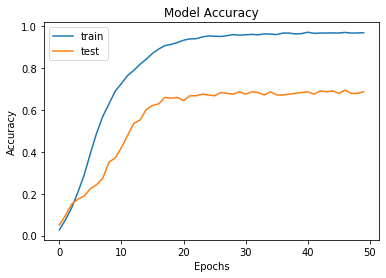

In [59]:
plt.plot(report.history['accuracy'])
plt.plot(report.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

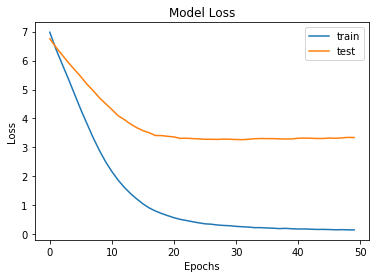

In [60]:
plt.plot(report.history['loss'])
plt.plot(report.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Discussion <a name='discussion'></a>

In this project, we successfully constructed a Job Recommendation machine, that makes the use of Natural Language Processing to recommend jobs to our need. Starting from data collection, we cleaned the data and created modified dataframes as per our requirement. We further devised a NLP algorithm and trained the dataset and thereafter used neural networks training to improve our model predictions. Finally, the model accuracy and model loss graphs were plotted.

## Conclusion <a name='conclusion'></a>

This is a fully functional job recommendation engine, which lists the most relevant 15 jobs according to your need. Might be in future, I will probably deploy it as an API or web application.